 Polina Lyubavina
 
 u0895721
 
 Homework #6

## HW 6: Character Classification using KNNs with PyTorch

In [307]:
# Imports and setup. 

import pandas as pd
import numpy as np

from sklearn import tree, svm, metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 18)
plt.style.use('ggplot')

import torchvision
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### Step 1: Data Acquisition + Cleanup

In [308]:
#read in the csv file
df = pd.read_csv('fonts/BASKERVILLE.csv')

df

,font,fontVariant,m_label,strength,italic,orientation,m_top,m_left,originalH,originalW,...,r19c10,r19c11,r19c12,r19c13,r19c14,r19c15,r19c16,r19c17,r19c18,r19c19
0,BASKERVILLE,BASKERVILLE OLD FACE,61442,0.4,0,0.0,33,21,46,34,...,1,92,183,238,255,255,255,244,203,111
1,BASKERVILLE,BASKERVILLE OLD FACE,61441,0.4,0,0.0,33,21,46,34,...,1,92,183,238,255,255,255,244,203,111
2,BASKERVILLE,BASKERVILLE OLD FACE,61440,0.4,0,0.0,32,23,48,41,...,43,43,129,237,255,214,53,4,1,1
3,BASKERVILLE,BASKERVILLE OLD FACE,9674,0.4,0,0.0,33,25,48,35,...,98,1,1,1,1,1,1,1,1,1
4,BASKERVILLE,BASKERVILLE OLD FACE,8805,0.4,0,0.0,38,22,41,28,...,249,249,249,249,249,249,249,249,249,249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,BASKERVILLE,BASKERVILLE OLD FACE,37,0.7,1,0.0,38,24,48,54,...,1,1,1,1,1,1,1,1,1,1
952,BASKERVILLE,BASKERVILLE OLD FACE,36,0.7,1,0.0,29,26,56,37,...,1,1,1,1,1,1,1,1,1,1
953,BASKERVILLE,BASKERVILLE OLD FACE,35,0.7,1,0.0,34,26,45,37,...,1,1,1,1,1,1,1,1,1,1
954,BASKERVILLE,BASKERVILLE OLD FACE,34,0.7,1,0.0,33,34,17,18,...,255,255,57,1,1,1,1,1,1,1


In [309]:
#function that takes a dataframe type and returns 2 numpy arrays: X's and Y's

def process_data(df):
    #throw away everything except for the m_label field and the pixel values which are scattered across 400 columns labeled rxcy
    df.drop(columns=['font', 'fontVariant', 'strength', 'italic', 'orientation', 'orientation', 'm_left', 'm_top', 'originalH', 'originalW', 'h', 'w'], 
        inplace=True)

    Y_raw = df["m_label"].to_numpy()
    keys, Y = np.unique(Y_raw, return_inverse=True)
    X = df.drop(columns="m_label").to_numpy(dtype=np.float64)
    X = np.array([x.reshape(20, 20) for x in X], dtype=np.float64) / 256
    X = np.reshape(X, (-1, 1, 20, 20))

    return X, Y, keys

X, Y, keys = process_data(df)

### Step 2: Build a PyTorch Network

In [310]:
# Try a different network.  Use more convolution layers and fewer dense layers, so fewer weights overall
class net1(nn.Module):
    def __init__(self):
        super(net1, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 8, 3)
        self.conv2 = nn.Conv2d(8, 64, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dense1 = nn.Linear(576, 1000)
        self.dense2 = nn.Linear(1000, 239)


    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))

        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.dense1(x))
        x = self.dense2(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net1 = net1()


In [311]:
def train( model, epochs, data, labels ): # One epoch uses the entire training set (one batch at a time) - 60,000 images in this case
    
    criterion = nn.CrossEntropyLoss() # this is a way of measuring error (loss) for classification that takes the
                                      # "confidence" of a prediction into account.  High confidence, correct predictions are low cost, 
                                      # high confidence, wrong predictions are high cost, medium confidence predictions have cost

    # use the ADAM optimizer to find the best weights
    optimizer = optim.Adam( model.parameters(), lr= 1e-4 )

    model.float()

    for epoch in range( epochs ): # loop over the dataset multiple times

        running_loss = 0.0
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(data.float()) #predict the output with some training data
        loss = criterion(outputs, labels) #see how well we did

        loss.backward() #see how to change the weights to do better
        optimizer.step() #and actually change the weights

        # print statistics
        running_loss += loss.item()

    print('Finished Training')

def evaluate( model, data, labels ):  
    #load some test data
    correct = 0
    total = 0

    with torch.no_grad(): # <- Since we are not training, the model does not need to calculate gradients
        outputs = model( data.float() )
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Just do a coarse evaluation... how many did we predict correcly?
    print( 'Accuracy of the network on the baskerville font images: %d %%' % ( 100 * correct / total) )

In [316]:
# Training and testing on baskerville font
data = torch.from_numpy(X)
labels = torch.from_numpy(Y)


print( "Training..." )
train( net1, 1500, data, labels)

print( "Evaluating..." )
evaluate( net1, data, labels )

Training...
Finished Training
Evaluating...
Accuracy of the network on the baskerville font images: 97 %


### Step 3: Exploration and Evaluation

In [444]:
# Try this first neural network with cross validation
kf = KFold(n_splits=5)


for train_index, test_index in kf.split(X):
    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = labels[train_index], labels[test_index]


    train( net1, 500, X_train, y_train)
    evaluate( net1, X_test, y_test )




Finished Training
Accuracy of the network on the baskerville font images: 70 %
Finished Training
Accuracy of the network on the baskerville font images: 94 %
Finished Training
Accuracy of the network on the baskerville font images: 93 %
Finished Training
Accuracy of the network on the baskerville font images: 93 %
Finished Training
Accuracy of the network on the baskerville font images: 97 %


As we train more, the model gets better, but it seems that the cross validated accuracy is around 89.4%.

In [331]:
# Try this first neural network with different fonts
# BELL, CENTAUR are good candidates

centaur = pd.read_csv('fonts/CENTAUR.csv')

centaurX, centaurY, keys = process_data(centaur)
data2 = torch.from_numpy(centaurX)
labels2 = torch.from_numpy(centaurY)
evaluate( net1, data2, labels2 )


Accuracy of the network on the baskerville font images: 42 %


The accuracy above on the centaur font is 42% accurate. This was one of the better ones that I could find, so it seems that the model doesn't generalize very well.

In [456]:
# Create a new network topology
# Try a different network.  Use more convolution layers and fewer dense layers, so fewer weights overall
class net2(nn.Module):
    def __init__(self):
        super(net2, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 8, 2)
        self.conv2 = nn.Conv2d(8, 64, 2)
        self.conv3 = nn.Conv2d(64, 128, 2)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dense1 = nn.Linear(128, 1000)
        self.dense2 = nn.Linear(1000, 239)
        self.dropout = nn.Dropout()


    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool3(F.relu(self.conv3(x))) # new 3rd conv layer

        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.dense1(x))
        x = self.dense2(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net2 = net2()

# Train and test the new network
print( "Training..." )
train( net2, 1500, data, labels)

print( "Evaluating..." )
evaluate( net2, data, labels )


Training...
Finished Training
Evaluating...
Accuracy of the network on the baskerville font images: 58 %


In [457]:
# Train best network on new, different fonts

bell = pd.read_csv('fonts/BELL.csv')
bellX, bellY, keys = process_data(bell)
data3 = torch.from_numpy(bellX)
labels3 = torch.from_numpy(bellY)

train( net1, 1000, data, labels)
train( net1, 1000, data3, labels3)

evaluate(net1, data, labels)
evaluate(net1, data3, labels3)


Finished Training
Finished Training
Accuracy of the network on the baskerville font images: 77 %
Accuracy of the network on the baskerville font images: 96 %


Can you find examples where the network is unsure of the result?

The network was not sure of the results with fonts that were most dissimilair from the one it was trained on and did poorly on those, either guessing confidently and getting the wrong answer or guessing unconfidently and getting the wrong answer. 

### Step 4: Denoising

Create and train a convolutional autoencoder to denoise these images the expected outputs are "clean" images

In [438]:
# the inputs are noisy images (original image + some guassian (normal) noise added (save to variable noisyX)
from PIL import Image

# img = Image.fromarray(np.uint8(X[700][0] * 255) , 'L')
# display(img)

def addRandomness(x):
    return max(min(x + np.random.normal() / 3, 1), 0)

noisyX = []

for entry in X:
    font_member = entry[0]
    noisy_font_member = np.vectorize(addRandomness)(font_member)
    noisyX.append(noisy_font_member)

for i in range(800, 805):
    img = Image.fromarray(np.uint8(noisyX[i] * 255) , 'L')
    display(img)

noisyX = torch.from_numpy(np.reshape(np.array(noisyX), (-1, 1, 20, 20)))


In [435]:
# Create denoiser
class CnnNet(nn.Module):
    def __init__(self):
        super(CnnNet, self).__init__()
        
        self.encodedSize = 32
        
        self.c1Out = 8 # filters from first conv layer
        self.c2Out = 8 # filters from 2nd conv layer
        
        #the padding here puts a "border" of 0s around the image, so that convolution layers don't "shrink" the image
        
        self.cv1 = nn.Conv2d(1, self.c1Out, 3, padding=1) #stick with 3x3 filters
        #output is 8x 28x28 images
        self.pool = nn.MaxPool2d(2,2)
        self.cv2 = nn.Conv2d(self.c1Out, self.c2Out, 3, padding=1)
        #reuse pool here
        
        self.downscaledSize = 20//4 #we add padding, so the conv2d layers don't change the size, just the max pools
        self.flattenedSize = self.downscaledSize*self.downscaledSize*self.c2Out
        
        self.fc1 = nn.Linear(self.flattenedSize, 64)
        self.fc2 = nn.Linear(64, self.encodedSize) #scale down to 64 features

        #now we're encoded, so go define decoding pieces
        
        self.fc3 = nn.Linear(self.encodedSize, 64) #scale down to 64 features
        self.fc4 = nn.Linear(64, self.flattenedSize)
        
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        # the padding is very important here so we don't have to guess a "frame" of pixels around the image
        self.cv3 = nn.Conv2d(self.c2Out, self.c1Out, 3, padding=1)
        # apply upsample again
        self.cv4 = nn.Conv2d(self.c1Out, 1, 3, padding=1)

        self.double()
        
        
    def compress(self, x):
        x = self.cv1(x)
        #print("shape after cv1", x.shape)
        x = F.relu(self.pool(x))
        #print("shape after pool1", x.shape)
        x = self.cv2(x)
        #print("after cv2", x.shape)
        x = F.relu(self.pool(x))
        #print("after pool 2", x.shape)
        x = x.view(-1, self.flattenedSize)
        #print("flattened shape", x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #now we have a low-d representation of our data.  If we were doing compression, we'd store this
        return x
    
    def decompress(self, x):
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        #print(x.shape)
        x = x.view(-1, self.c2Out, self.downscaledSize, self.downscaledSize)
        #print("unflattened shape", x.shape)
        x = self.upsample(x)
        #print("upsample", x.shape)
        x = F.relu(self.cv3(x))
        #print(x.shape, "after cv3")
        x = self.cv4(self.upsample(x))
        #print(x.shape, "after both upsamples")
        return x
    
    def forward(self, x):
        x = self.compress(x)
        x = self.decompress(x)
       
        return x

cnnNet = CnnNet() # treat these as just 28 D vectors

#same as we did before except for the reshaping.  CNNs understand 2D images, so we don't want to flatten

# mean-squared error loss
# this is the normal "least squares" error function, divided by the number of data points
criterion = nn.MSELoss()

def trainCNN(model, epochs):
    # create an optimizer object
    # Adam optimizer with learning rate 1e-3
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    
    
    train_loader = torch.utils.data.DataLoader(noisyX, batch_size=8, shuffle=False, num_workers=0)
    test_loader = list(torch.utils.data.DataLoader(X, batch_size=8, shuffle=False, num_workers=0))
    
    for epoch in range(epochs):
        loss = 0
        
        running_loss = 0
        
        for i, data in enumerate(train_loader, 0):
            # reset the gradients back to zero
            # PyTorch accumulates gradients on subsequent backward passes
            optimizer.zero_grad()
        
            # compute reconstructions
            outputs = model(data)
            # compute loss
            train_loss = criterion(outputs, test_loader[i])
        
            # compute accumulated gradients
            train_loss.backward()
        
            # perform parameter update based on current gradients
            optimizer.step()
        
            # add the mini-batch training loss to epoch loss
            loss += train_loss.item()
    
            # print statistics
            running_loss += train_loss.item()
            if i % 20 == 19:    # print every 20 mini-batches
                print('[%d, %5d] loss: %.8f' % (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0

    
        # compute the epoch training loss
        loss = loss / len(train_loader)
    
        # display the epoch training loss
        print("epoch : {}/{}, loss = {:.8f}".format(epoch + 1, epochs, loss))

def evaluateCNN(model):
    test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=8, shuffle=True, num_workers=0)
    total_loss = 0
    with torch.no_grad():
        for data in test_loader:
            images = data[0]
            outputs = model(images)
            test_loss = criterion(outputs, images)
            total_loss += test_loss.item()

    print("overall loss: ", total_loss)

In [436]:
# Denoise the images
trainCNN(cnnNet, 100)

[1,    20] loss: 0.01097158
[1,    40] loss: 0.00728676
[1,    60] loss: 0.00746533
[1,    80] loss: 0.01174195
[1,   100] loss: 0.00876157
[1,   120] loss: 0.00762982
epoch : 1/100, loss = 0.20000587
[2,    20] loss: 0.00875726
[2,    40] loss: 0.00727674
[2,    60] loss: 0.00715552
[2,    80] loss: 0.01047701
[2,   100] loss: 0.00886489
[2,   120] loss: 0.00746745
epoch : 2/100, loss = 0.16811794
[3,    20] loss: 0.00858581
[3,    40] loss: 0.00698946
[3,    60] loss: 0.00701359
[3,    80] loss: 0.01007769
[3,   100] loss: 0.00845039
[3,   120] loss: 0.00722833
epoch : 3/100, loss = 0.15803131
[4,    20] loss: 0.00817161
[4,    40] loss: 0.00645922
[4,    60] loss: 0.00641037
[4,    80] loss: 0.00891244
[4,   100] loss: 0.00832716
[4,   120] loss: 0.00664547
epoch : 4/100, loss = 0.14371018
[5,    20] loss: 0.00766398
[5,    40] loss: 0.00621179
[5,    60] loss: 0.00621152
[5,    80] loss: 0.00839104
[5,   100] loss: 0.00776241
[5,   120] loss: 0.00640732
epoch : 5/100, loss = 0.1357

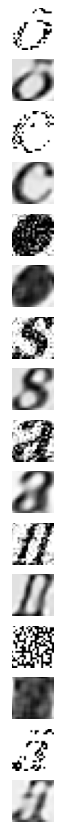

In [434]:
#Create a plot showing the noisy and denoised versions of some inputs to verify 
#that your denoiser had the desired effect.
def drawComparisons( model ):

    plt.figure( figsize=(20, 15) )

    test_loader = torch.utils.data.DataLoader( noisyX[700:900], batch_size=8, shuffle=True, num_workers=0 )
    
    for i, batch in enumerate( test_loader ):
        if i >= 8:
            break
        images = batch[0]
        #print(images.shape)
        with torch.no_grad():
            reconstructed = model(images)
            for j in range( len(images) ):
                # Display the original image
                ax = plt.subplot(16, 8, i*16 + j + 1)
                plt.imshow(images[j].reshape((20,20)), cmap="Greys", interpolation=None)
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
            
                # and the reconstructed version in the next row
                ax = plt.subplot(16, 8, i*16 + j + 1 + 8)
                plt.imshow(reconstructed[j].reshape((20,20)), cmap="Greys", interpolation=None)
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)

drawComparisons(cnnNet)
